# Model Tunning
The purpose of this notebook is to find the optimal parameters of the model that will be used in order to classify audio files into 5 emotional categories.
There are many ways to represent audio files, but in this specific project, we choose to convert each audio file to a vector of numerical features, and then
use a neural network (ANN) to make the classification.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

## Data Reading
In this part, we read the data and store them to a dataframe

In [2]:
INPUT_FILE = 'converted_audio.csv'

df = pd.read_csv(INPUT_FILE)
df.head()

,mfcc,chroma,mel,label
0,-295.98865~105.36255~-16.353527~5.4801188~-17....,0.6021514~0.48702985~0.45771214~0.4722117~0.42...,1.5608983e-05~0.00020586695~0.0015100229~0.050...,anger
1,-308.15204~119.90065~-23.716702~-9.39748~-22.8...,0.6032951~0.5813256~0.61445487~0.57001597~0.45...,4.3338773e-06~1.0461925e-05~5.4465807e-05~0.00...,anger
2,-305.94824~110.138985~-13.923437~17.175982~-19...,0.66323256~0.6077178~0.6698733~0.70354384~0.65...,6.722516e-05~0.0027697557~0.09731158~0.9607768...,anger
3,-286.55246~118.74021~-25.84763~20.624996~-28.5...,0.6495695~0.682862~0.7412222~0.70849925~0.6580...,4.422941e-05~0.0014562423~0.05136057~0.6052398...,anger
4,-322.03024~99.978195~-34.859497~10.481912~-0.5...,0.5436057~0.5823237~0.59510565~0.58050835~0.53...,0.0018223199~0.0021862376~0.0032291228~0.00397...,anger


In [3]:
# let's see more details about the dataframe
print("Number of samples:", df.shape[0])   # check how many samples we have
print("Columns in our dataframe:", df.columns)  # see all the columns of the df
print('Data type of features:', type(df['mfcc'][0]))  # check the type of the features

Number of samples: 604
Columns in our dataframe: Index(['mfcc', 'chroma', 'mel', 'label'], dtype='object')
Data type of features: <class 'str'>


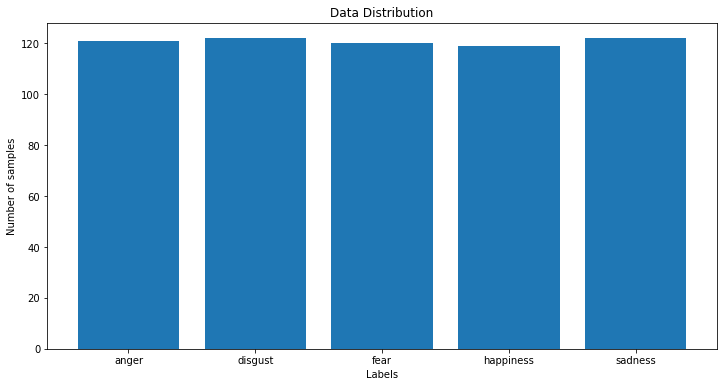

In [4]:
# let's see how many samples belong to each category (label)
sample_ratios = Counter(list(df['label']))   # returns a dictionary-like data structure, with keys the unique labels, and values the number of times they are encountered

# create a bar plot for better visual understanding
plt.figure(figsize=(12,6))
plt.bar(*zip(*sample_ratios.items()))
plt.xlabel('Labels')
plt.ylabel('Number of samples')
plt.title('Data Distribution')
plt.show()

## Preparing the data to be used as input to the model
In the previous part, we imported the data we need. We also saw that the number of samples is almost the same in all categories, which 
means that we don't have bias towards one specific category (for example if anger had 90% of all samples, then the model would be closer to classifying a new image as anger, because it 
does not have enough data to understand that it resembles another category). Now, it is time to process those data and prepare them to train he model.

In [5]:
# First, we need to convert the feature values from str to array

df['features'] = df['mfcc'] + '~' + df['chroma'] + '~' + df['mel'] # concat all columns into a new one

features_as_string = list(df['features'])   # get the new column, containing all the features
features = list(map(lambda x: x.split('~'), features_as_string))   # convert from string to list

print(type(features[0]))  # check that everything went fine --> should be <class 'list'>

<class 'list'>


In [7]:
# also, turn the list of str to np.array of float

def convert_to_float_array(l):   # helping function
    float_l = list(map(float, l))
    return np.array(float_l)


features = list(map(convert_to_float_array, features))
print(type(features[0]))

<class 'numpy.ndarray'>


In [9]:
# check the dimension of the reformatted input
print('Shape of the new input:', features[0].shape)

Shape of the new input: (180,)


In [11]:
# make sure that all input samples have the same dimensions

input_shape = features[0].shape[0]   # will also be used later when we define the input shape of the neural network's first layer
for f in features[1:]:
    assert f.shape[0] == input_shape

print('Input shape is OK')

Input shape is OK


In [12]:
# extract labels
labels = list(df['label'])

# encode the labels
label_encoding = {
    'anger': 0,
    'disgust': 1,
    'fear': 2,
    'happiness': 3,
    'sadness': 4
}

labels = list(map(lambda x: label_encoding[x], labels))

print(labels[1])  # check that the encoding worked

0


In [23]:
# turn labels and features to np.array
features, labels = np.array(features), np.array(labels)

In [24]:
# split the data, using a 70%-30% analogy for training and testing data respectively
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, train_size=0.7)

## Hyperparameter Tuning
In this part, we will use brute-force in order to find the optimal parameters of the model. The process we will follow consists of the below steps:
1. Create a model with specific parameter values
2. Train the model with the training dataset
3. Evaluate the model using the testing dataset
4. Compare the results with those for other parameters values and pick the best one.

In [19]:
# first we will make a custom function that creates a model - for this project we will only use 2 dense layers, followed by a dropout layer
def create_model(d1, d2, dr):
    model = keras.models.Sequential()    
    model.add(layers.Dense(d1, input_shape=(input_shape,)))                        
    model.add(layers.Dense(d2, activation='relu'))      
    model.add(layers.Dropout(dr))
    model.add(layers.Dense(5))   # the output layer, it contains 5 neurons , since it has 5 possible categories
    
    return model

In [26]:
# finding optimal parameters

# possible parameter values that will be tried
EPOCHS = [25, 50, 100]
FIRST_LAYER = [4, 8, 16, 32, 64]    # first dense layer
SECOND_LAYER = [4, 8, 16, 32, 64]   # second dense layer
DROP_LAYER = list(np.linspace(0, 0.5, num=5))  # dropout layer


max_acc = 0
best_params = []

for f in FIRST_LAYER:
    for s in SECOND_LAYER:
        for d in DROP_LAYER:
            for e in EPOCHS:
                model = create_model(f, s, d)  # create the architecture of the model
                    
                model.compile(      # compiling the model
                    optimizer='adam',   # optimizer function
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # loss/cost function
                    metrics=['accuracy']   # metrics that we are interested in
                )
                    
                model.fit(train_data, train_labels, epochs=e, validation_data=(test_data, test_labels), verbose=0)  # training the model
                              
                test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)  # in order to avoid large output, we set verbose=0 (silent)
                
                # compare current accuracy with previous max, and update the best_params and max_acc accordingly
                if test_accuracy > max_acc:
                    max_acc, best_params = test_accuracy, [f, s, d, e]
                    #print('Temporary best parameters:')
                    #print(best_params)
                    print('Temporary best accuracy:', str(max_acc))


print("Best parameters were found to be:")
print(best_params)
print("Maximum Accuracy Achieved:", str(max_acc))

Temporary best accuracy: 0.3131868243217468
Temporary best accuracy: 0.4395604431629181
Temporary best accuracy: 0.6208791136741638
Temporary best accuracy: 0.6263736486434937
Temporary best accuracy: 0.6373626589775085
Temporary best accuracy: 0.7142857313156128
Temporary best accuracy: 0.7197802066802979
Temporary best accuracy: 0.7307692170143127
Temporary best accuracy: 0.7362637519836426
Temporary best accuracy: 0.7417582273483276
Temporary best accuracy: 0.7747252583503723
Best parameters were found to be:
[16, 64, 0.25, 100]
Maximum Accuracy Achieved: 0.7747252583503723


In [35]:
# further investigation on optimal number of epochs
optimal_model = create_model(best_params[0], best_params[1], best_params[2])  # creating the model with the optimal parameters

optimal_model.compile(   # compiling the model
    optimizer='adam',   # optimizer function
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # loss/cost function
    metrics=['accuracy']   # metrics that we are interested in
)

history = optimal_model.fit(train_data, train_labels, epochs=200, validation_data=(test_data, test_labels), verbose=0)

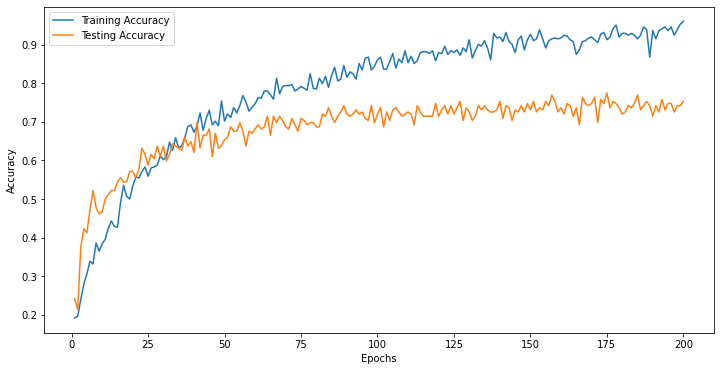

In [38]:
# plot a diagramm to check for overfitting/underfitting
epochs = [i for i in range(1,201)]

plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above diagramm, it seems that after 100 epochs the model's val_accuracy stops increasing. As such, we can assume that 100 epochs are optimal enough to avoid both overfitting and underfitting.